<a href="https://colab.research.google.com/github/alaaosama72/Social-media-crisis-For-Brands/blob/main/sentiment_bert_94_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch tqdm imbalanced-learn emoji

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 37.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
data = pd.read_csv('/content/cleaned_tweets (3).csv')  # غيّر المسار حسب الملف عندك

data = data.dropna(subset=['final_text', 'airline_sentiment'])

In [ ]:
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['label'] = data['airline_sentiment'].map(label_mapping)


In [ ]:
X = data['final_text'].values
y = data['label'].values


In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)


In [ ]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TweetDataset(X_train, y_train, tokenizer)
val_dataset = TweetDataset(X_val, y_val, tokenizer)
test_dataset = TweetDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
epochs = 5

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class_weights = torch.tensor([0.52, 1.62, 2.20], dtype=torch.float).to(device)


In [ ]:
model.train()
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    total_train_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = torch.nn.CrossEntropyLoss(weight=class_weights)(logits, labels)

        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f'Average Training Loss: {avg_train_loss:.4f}')


Epoch 1/5


100%|██████████| 586/586 [03:08<00:00,  3.10it/s]


Average Training Loss: 0.3804
Epoch 2/5


100%|██████████| 586/586 [03:16<00:00,  2.99it/s]


Average Training Loss: 0.1797
Epoch 3/5


100%|██████████| 586/586 [03:15<00:00,  2.99it/s]


Average Training Loss: 0.0945
Epoch 4/5


100%|██████████| 586/586 [03:15<00:00,  3.00it/s]


Average Training Loss: 0.0675
Epoch 5/5


100%|██████████| 586/586 [03:15<00:00,  3.00it/s]

Average Training Loss: 0.0481


In [ ]:
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = torch.nn.CrossEntropyLoss(weight=class_weights)(logits, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Average Validation Loss: {avg_val_loss:.4f}')
    model.train()

Average Validation Loss: 0.4741


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"\nTest Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['negative', 'neutral', 'positive']))



Test Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1859
     neutral       0.91      0.77      0.83       607
    positive       0.75      0.90      0.82       462

    accuracy                           0.94      2928
   macro avg       0.89      0.89      0.88      2928
weighted avg       0.94      0.94      0.94      2928



<ipython-input-13-1419972592>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=data, palette='Set2')


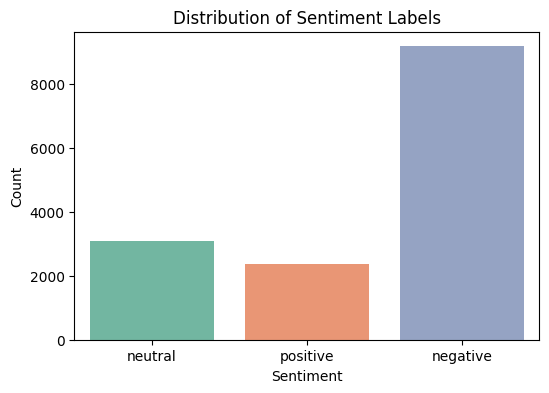

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=data, palette='Set2')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


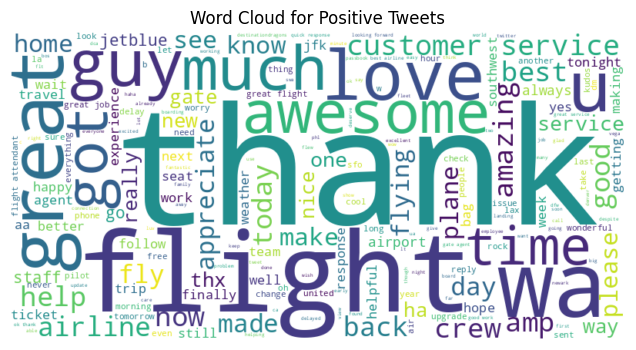

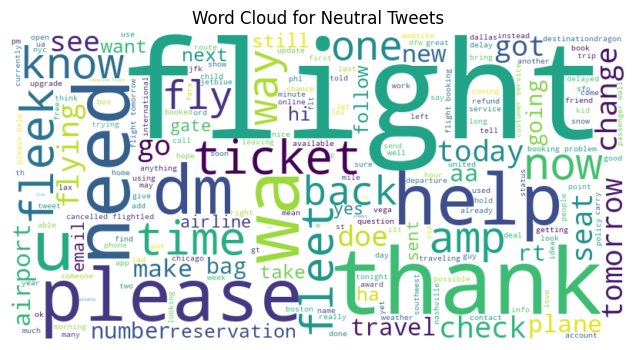

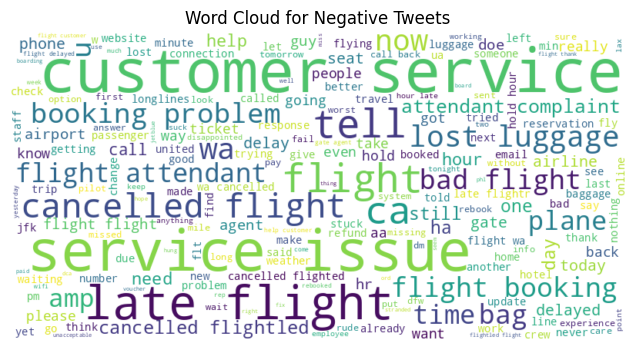

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for sentiment in ['positive', 'neutral', 'negative']:
    text_series = data[data['airline_sentiment'] == sentiment]['final_text'].dropna().astype(str)
    text = ' '.join(text_series)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Tweets")
    plt.axis('off')
    plt.show()

<Figure size 600x600 with 0 Axes>

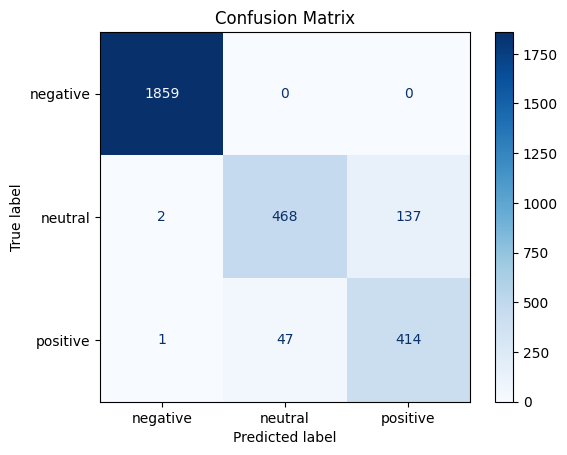

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install transformers
!pip install flask
!pip install pyngrok


In [ ]:
# احفظي المودل والـ tokenizer
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')

# أو احفظي المودل كـ state_dict
torch.save(model.state_dict(), 'sentiment_model.pth')

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as F

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("sentiment_model")
tokenizer = BertTokenizer.from_pretrained("sentiment_model")
model = model.to(device)
model.eval()

# Function to predict sentiment
def predict_sentiment(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class, probs.cpu().numpy()


In [ ]:
from flask import Flask, request, jsonify
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as F

app = Flask(__name__)

# Load model and tokenizer
model_path = "sentiment_model"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

label_map = {
    0: 'Neutral',
    1: 'Positive',
    2: 'Negative'
}

def predict_sentiment(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    return label_map[pred_class], probs.cpu().numpy().tolist()[0]

@app.route("/predict", methods=["POST"])
def predict():
    data = request.json
    text = data.get("text", "")
    if not text:
        return jsonify({"error": "No text provided"}), 400

    label, probs = predict_sentiment(text)
    return jsonify({
        "sentiment": label,
        "probabilities": {
            "Neutral": probs[0],
            "Positive": probs[1],
            "Negative": probs[2]
        }
    })

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
!pip install pyngrok
from pyngrok import ngrok
public_url = ngrok.connect(5000)
print(public_url)


NgrokTunnel: "https://ff9c-34-168-189-0.ngrok-free.app" -> "http://localhost:5000"
